In [1]:
import os
import json
import re
import ast
import numpy as np
import matplotlib.pyplot as plt
from openai import OpenAI

client = OpenAI(
    base_url="https://api.chatanywhere.tech/v1"
)

def chat(says):
    chat_completion = client.chat.completions.create(
        messages=[
            {
                "role": "user",
                "content": says,
            }
        ],
        model="gpt-4o-2024-05-13",
    )
    print("bots: "+chat_completion.choices[0].message.content)
    return  chat_completion.choices[0].message.content

def obj(x,y):
    return (x-2)**2+(y-3)**2

with open("prompt.txt","r",encoding="utf-8") as file:
    says = file.read()

def Getvalue(ch,str):
    s = str.find(ch)
    e = str[s+1:].find(ch)
    return str[s+1:s+e+1]

def warm_strat(num):
    flag  = 1 #Determine whether the output meets the format.
    while flag:
        pt = (
            "You need to assume {} initial points for an optimization problem, and the objective function corresponding to the initial points should be as small as possible."
            "The objective function of this task is a binary quadratic function."
            "x1 must be within the range of [-5, 5]. x2 must be within the range of [-5, 5]."
            "According to the experience of previous tasks, the minimum value of the objective function may be around x1, x2 = 3, 3."
            "Please do not provide duplicate values."
            "Please give your answer and format your output as follows: *[],[],[],...,[]*").format(num)
        datas = Getvalue("*",chat(pt))
        datas = "[" + datas + "]"
        datas =  ast.literal_eval(datas)
        if len(datas) == num:
            flag = 0
    return datas

def candidate_sampling(history,num):
    flag  = 1 #Determine whether the output meets the format.
    while flag:
        pt = (
            "Based on the previous optimization results {}, you need to provide {} candidate points for the next optimization."
            "The objective function of this task is a binary quadratic function."
            "x1 must be within the range of [-5, 5]. x2 must be within the range of [-5, 5]."
            "Please do not provide duplicate values."
            "Please give your answer and format your output as follows: *[],[],[],...,[]*").format(json.dumps(history),num)
        datas = Getvalue("*",chat(pt))
        datas = "[" + datas + "]"
        datas =  ast.literal_eval(datas)
        if len(datas) == num:
            flag = 0
    return datas
    
def SurrogateModel(history,samples):
    data_pred = []
    for i in range(len(samples)):
        flag  = 1 #Determine whether the output meets the format.
        while flag:
            pt = ("You are helping tune hyperparameters to minimize loss(>0)."
                "The objective function of this task is a binary quadratic function."
                "You need to guess the target function value for a given x based on historical evaluation data."
                "Below is the historical evaluation data, formatted as [Hyperparameters] - [loss]:"
                "{}"
                "As short as possible, do not provide too much information."
                "Please guess the loss for params:{} and format your output as follows: *xx*").format(history,samples[i])
            loss = re.findall(r'-?\d+\.\d+|-?\d+', Getvalue("*",chat(pt)))
            if len(loss) == 1:
                flag = 0
                new_entry = {"params": samples[i], "loss": float(loss[0])}
                data_pred.append(new_entry)
    return data_pred

In [2]:
numiters = 10
inidatas = warm_strat(3)
datas = []
arrloss = []
for i in inidatas:
    loss = obj(i[0],i[1])
    new_entry = {"params": [i[0], i[1]], "loss": loss}
    datas.append(new_entry)

bots: Based on the constraints and the experience from previous tasks, here are three initial points that are spread around the area where the minimum value is suspected to be (x1, x2 = 3, 3):

*[2.5, 3.5], [3.0, 2.5], [3.5, 3.0]*


In [3]:
from tqdm import tqdm
for i in tqdm(range(numiters)):
    samplers = candidate_sampling(datas,5)
    data_pred = SurrogateModel(datas,samplers)
    next_point = min(data_pred, key=lambda x: x['loss'])
    loss = obj(next_point["params"][0],next_point["params"][1])
    arrloss.append(loss)
    new_entry = {"params": next_point["params"], "loss": loss} 
    datas.append(new_entry)

  0%|          | 0/10 [00:00<?, ?it/s]

bots: Sure! Here are five candidate points for the next optimization:

*[2.75, 3.0], [3.25, 2.75], [2.5, 2.5], [3.0, 3.25], [2.25, 3.25]*
bots: *0.625*
bots: *1.75*
bots: *0.5*
bots: *1.0*


 10%|█         | 1/10 [00:05<00:47,  5.31s/it]

bots: *0.25*
bots: *[2.0, 3.0], [2.75, 3.0], [2.25, 2.75], [2.0, 3.5], [3.0, 3.25]*
bots: *0.5*
bots: The guessed loss for params: [2.75, 3.0] is *0.625*.
bots: *0.8125*
bots: *0.5*


 20%|██        | 2/10 [00:10<00:40,  5.05s/it]

bots: *1.0*
bots: Based on the previous optimization results and the requirement to provide 5 candidate points within the range of [-5, 5] for \(x_1\) and \(x_2\) without duplicating values, we should consider points near the optimal candidate so far ([2.0, 3.0] with a loss of 0.0) but also ensure diversity to explore the parameter space.

Here are 5 candidate points:
* [1.75, 3.0], [2.0, 2.75], [2.25, 2.75], [1.5, 3.5], [2.5, 2.5] *

These points are close to the current optimal point and spread within the given range for further exploration to find the minimum loss.
bots: *0.25*
bots: *0.0625*
bots: *0.25*
bots: *1.75*


 30%|███       | 3/10 [00:16<00:38,  5.51s/it]

bots: *1.0*
bots: Based on the previous optimization results, it appears that lower values for `x1` and values around 3 for `x2` result in lower losses. Thus, my candidate points will explore around these regions to further investigate the minimum.

Here are 5 candidate points for the next optimization:
*[1.75, 3.0], [2.0, 2.5], [2.25, 2.75], [1.5, 3.25], [1.75, 2.75]*
bots: *0.3125*
bots: *0.25*
bots: **0.25**
bots: *0.125*
bots: *0.625*


 40%|████      | 4/10 [00:23<00:36,  6.03s/it]

bots: *0.5*
bots: * [2.0, 3.25], [2.25, 3.0], [2.0, 2.5], [1.75, 3.0], [2.0, 3.5] *
bots: *0.0625*
bots: *0.0625*
bots: *0.25*
bots: *0.0625*


 50%|█████     | 5/10 [00:28<00:29,  5.91s/it]

bots: *0.25*
bots: Based on the given previous optimization results and the behavior of the loss function, which appears to be lower near [2.0, 3.0], we can generate candidate points by exploring around this region while ensuring a diverse set of trial points. 

Here are 5 candidate points for the next optimization:

*[-1.5, 4.0], [1.5, 3.0], [2.0, -1.0], [3.0, 2.0], [-2.5, 3.5]*
bots: *22.25*
bots: *0.25*
bots: *16*
bots: *1.0*


 60%|██████    | 6/10 [00:36<00:25,  6.48s/it]

bots: *20.5*
bots: Based on the optimization results, it appears that lower values of \( x_1 \) (around 2.0) and \( x_2 \) (around 3.0) tend to yield better results in terms of minimizing loss. Hence, we can explore values in the proximity of these promising parameters while also sampling the search space to explore other potentially good candidates.

Here are 5 candidate points for the next round of optimization:

*[2.1, 3.0], [2.0, 2.85], [1.9, 3.1], [2.15, 2.95], [1.8, 3.2]*
bots: *0.01*
bots: *0.0075*
bots: *0.01*
bots: *0.0225*


 70%|███████   | 7/10 [00:43<00:19,  6.64s/it]

bots: *0.02*
bots: Based on the previous optimization results and aiming to further reduce the loss of the binary quadratic function, here are five candidate points for the next optimization:

*[2.0, 2.9], [1.75, 3.15], [2.0, 3.15], [2.1, 3.05], [1.85, 2.95]*
bots: *0.01*
bots: *0.125*
bots: ```0.0225```
bots: *0.0104*


 80%|████████  | 8/10 [00:50<00:13,  6.65s/it]

bots: *0.0075*
bots: *[1.95, 3.05], [2.05, 2.95], [2.0, 2.90], [2.10, 2.90], [1.9, 3.1]*
bots: *0.0125*
bots: *0.0225*
bots: *0.01*
bots: *0.01*


 90%|█████████ | 9/10 [00:54<00:06,  6.04s/it]

bots: *0.05*
bots: Here are 5 candidate points for the next optimization:

* [2.0, 2.8],
[2.15, 2.9],
[1.75, 3.0],
[1.95, 2.9],
[2.05, 2.85] *
bots: *0.04*
bots: *0.0575*
bots: *0.0625*
bots: *0.0125*


100%|██████████| 10/10 [00:59<00:00,  5.96s/it]

bots: *0.0225*


13


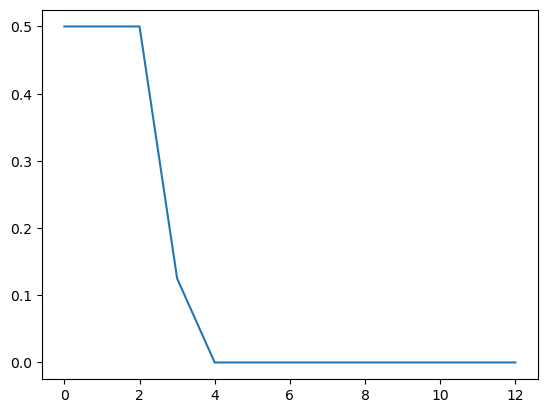

In [16]:
minn = 1e10
print(len(datas))
losses = []
for i in range(13):
    minn = min(minn,datas[i]["loss"])
    losses.append(minn)
plt.plot(losses)
plt.show()

|   iter    |  target   |     x     |     y     |
-------------------------------------------------
| 1         | -0.5      | 2.5       | 3.5       |
| 2         | -1.25     | 3.0       | 2.5       |
| 3         | -2.25     | 3.5       | 3.0       |
| 4         | -53.54    | -3.912    | -1.311    |
| 5         | -73.0     | 5.0       | -5.0      |
| 6         | -53.0     | -5.0      | 5.0       |
| 7         | -13.0     | 5.0       | 5.0       |
| 8         | -6.609    | 0.3846    | 5.0       |
| 9         | -2.605    | 0.4606    | 2.515     |
| 10        | -0.4948   | 1.349     | 3.266     |
| 11        | -2.341    | 1.541     | 1.541     |
| 12        | -0.1542   | 1.881     | 2.626     |
| 13        | -4.051    | 2.226     | 5.0       |


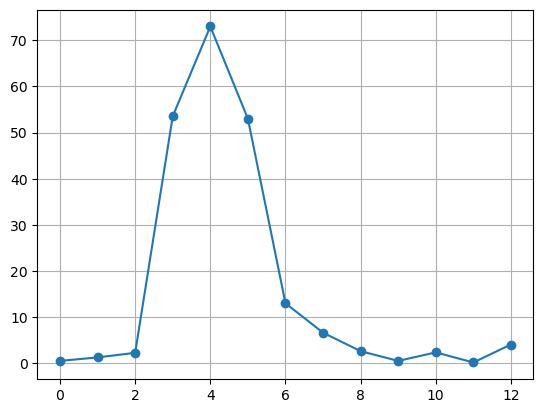

In [6]:
from bayes_opt import BayesianOptimization
pbounds = {'x': (-5, 5), 'y': (-5, 5)}
def target_function(x, y):
    return -(x-2)**2 - (y - 3)**2

optimizer = BayesianOptimization(
    f=target_function,
    pbounds=pbounds,
    random_state=1,
)

initial_points = []
for i in range(3):
    new_entry = {'x': inidatas[i][0], 'y': inidatas[i][1]}
    initial_points.append(new_entry) 

for point in initial_points:
    optimizer.probe(
        params=point,
        lazy=True
    )

# 执行优化
optimizer.maximize(
    init_points=0,
    n_iter=10,
)

target_values = [res['target'] for res in optimizer.res]
plt.plot(target_values, marker='o')
plt.grid(True)
plt.show()